In [1]:
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import obspy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


# base paths for the PICTS data
PICTS_BASE_PATH = "/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data"
PICTS_DATA_PATHS = ["PICTS_DATA/",
                    "/PICTS_pullout_partial/"]
# file containing PICTS station info
STATION_INFO = "/home/dv1/Documents/Projects_&_Code/2023_QUADRAT/dev/training20230807/waves_metadata_generator/picts_network_info.csv"

# read the station info
station_info = pd.read_csv(STATION_INFO, header=[0])
# create random number generator
rng = np.random.default_rng(seed=34536464352)

## About the models
The retrained model was a PhaseNet model pretrained on the STEAD dataset, and then retrained for 100 epochs on a significant portion of the PICTS data. Loading the retrained model along with PhaseNet pretrained on STEAD, so that we can see what effect the retraining has had, and also EQTransformer ('original', which is trained on STEAD also).  
EQTransformer has been the best performer in previous comparisons, but issues in its training code were taking me a lot of time to resolve so I eventually gave up and switched to training PhaseNet, which worked straight away without me adjusting anything else in the training scripts that I'd written.

In [2]:
retrained_model = sbm.PhaseNet().load("/home/dv1/Documents/Projects_&_Code/2023_QUADRAT/dev/training20230814/retrained_models/phasenet_man_pick_1", version_str="1")
reference_model = sbm.PhaseNet.from_pretrained("stead")
eqtrans_model = sbm.EQTransformer.from_pretrained("original")
models = {"retrained_PhaseNet": retrained_model, "reference_PhaseNet": reference_model, "EQTransformer": eqtrans_model}

Loading the testing data, and checking the size of the train / dev / test split that was used

In [3]:
data = sbd.WaveformDataset("/home/dv1/Documents/Projects_&_Code/2023_QUADRAT/dev/training20230814/generated_training_data/", sampling_rate=100, missing_componens="pad")
train, dev, test = data.train_dev_test()
print(len(data))
print(f"train size: {len(train)} \ndev size: {len(dev)} \ntest size: {len(test)}")

34
train size: 23 
dev size: 5 
test size: 6


## Checking the models against some PICTS streams
Re-run this cell to see a different example each time (make sure to update PICTS_BASE_PATH at the top of this notebook first). Below it I list some thoughts and some 'hardcoded' examples for ease of viewing.

/tmp/ipykernel_75247/442264835.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  path_main = PICTS_DATA_PATHS[int(rng.integers(low=0, high=2, size=1))]


/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2023/9J/G3GB/HHZ.D/9J.G3GB.00.HHZ.D.2023.074




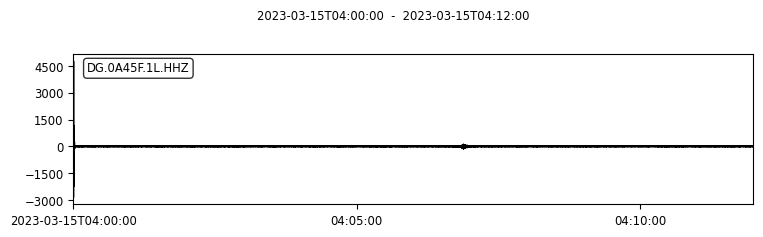

retrained_PhaseNet


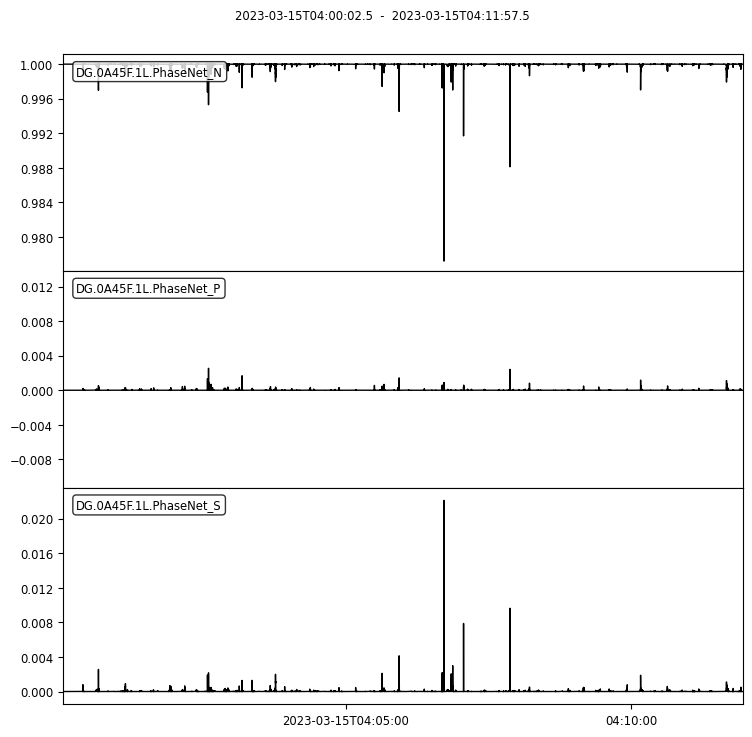

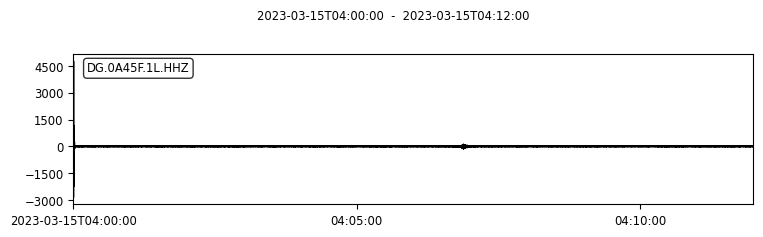

reference_PhaseNet


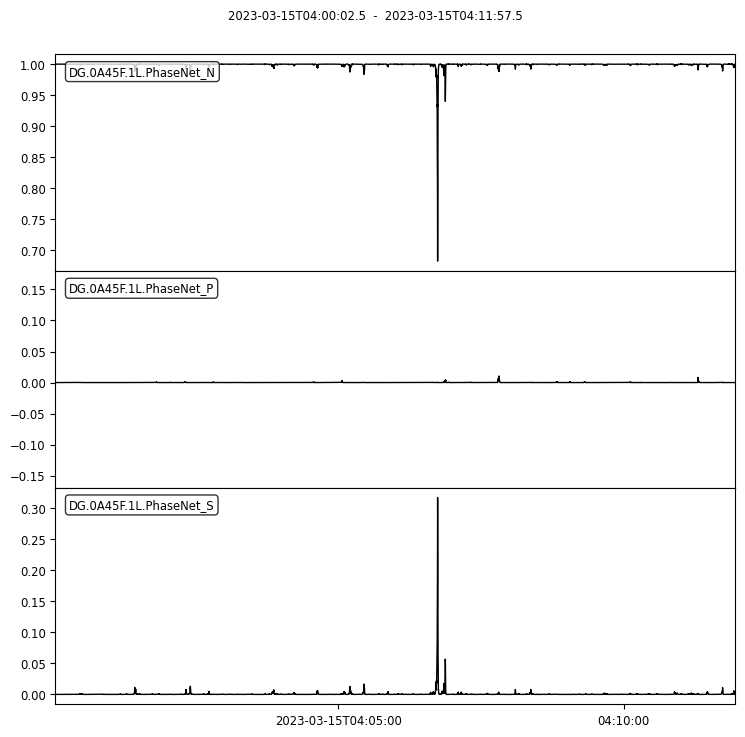

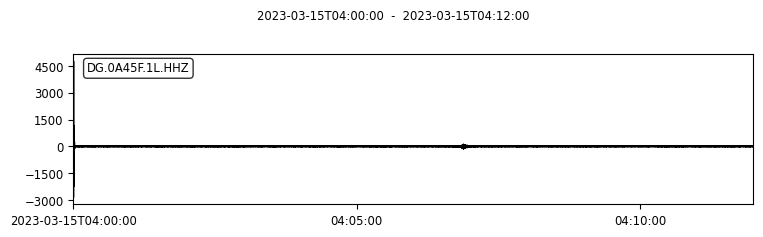

EQTransformer


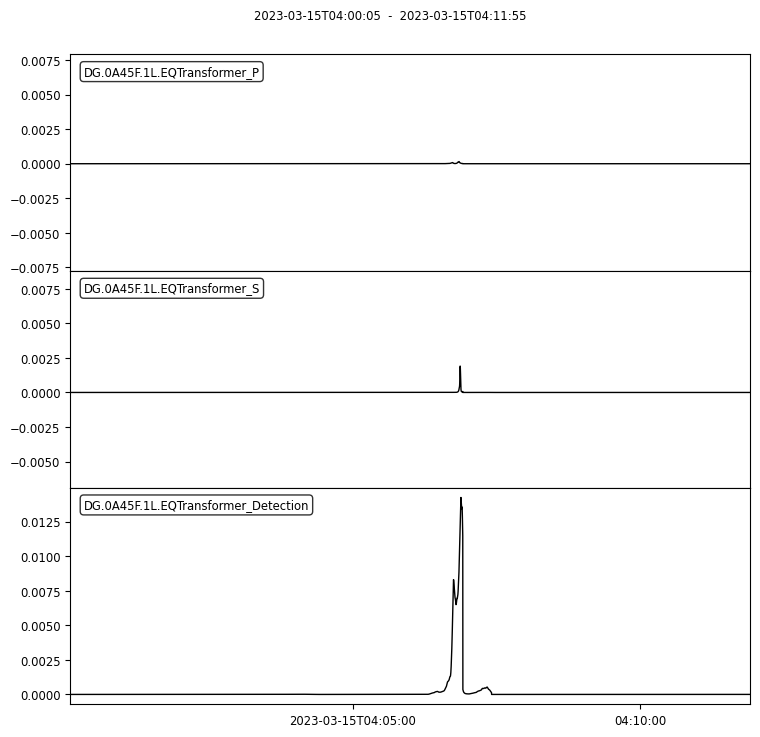

In [4]:
def get_random_filepath():
    """ Returns a random PICTS data filepath """
    while True:
        selected_file = str()
        path_main = PICTS_DATA_PATHS[int(rng.integers(low=0, high=2, size=1))]
        year = str(rng.integers(low=2022, high=2024))
        station_index = int(rng.integers(low=0, high=len(station_info)))
        network = station_info.loc[station_index, "network"]
        name = station_info.loc[station_index, "name"]
        sensor = ["HHE.D", "HHN.D", "HHZ.D"][int(rng.integers(low=0, high=3))]
        path = os.path.join(PICTS_BASE_PATH, path_main, year, network, name, sensor)
        file_list = list()
        for root, dirs, files in os.walk(path):
            for file in files:
                if not file.startswith("."):
                    file_list.append(os.path.join(root, file))
        list_length = len(file_list)
        if list_length > 2:
            selected_file = file_list[int(rng.integers(low=0, high=list_length))]
        if os.path.isfile(selected_file):
            j_day = selected_file.split(".")[-1]
            j_day = j_day.zfill(3)
            yr = year
            start_time = obspy.UTCDateTime(f"{yr}{j_day}T000000.0") + 60 * 60 * 4
            end_time = obspy.UTCDateTime(f"{yr}{j_day}T000000.0") + 60 * 60 * 4.2
            return selected_file, start_time, end_time


file, start, end = get_random_filepath()
print(file)
stream = obspy.read(file, starttime=start, endtime=end)
stream.filter("bandpass", freqmin=2, freqmax=8)

for name, model in models.items():
    print("\n")
    stream.plot()
    print(name)
    annotations = model.annotate(stream)
    annotations.plot()

## Thoughts
Running through a number of examples (I'll put some of them below), it looks to me that EQTransformer 'original' still on average gives the best results, followed by PhaseNet 'STEAD'. Retraining PhaseNet 'STEAD' on the PICTS data appears to have reduced its average accuracy, although occassionally it does the best out of the 3 models. I think the most likely ways to improve the retraining lie with the generate_csv_hdf5.py script I wrote (the majority of train_via_SB.py follows examples from the seisbench docs & I don't see much room for improvement):
- Currently using TauPyModel(model="ak135") to define the metadata for P & S arrival; this is then used in train_via_SB.py with a probabalistic labeller (sigma=45) to label the training data; a more accurate method may be needed
- The random train / dev / test split I have defined may not be optimal; I will look to eliminate 'test' and just use PICTS streams instead, so that there is more data for training
- The training data is selected using data from BGS earthquakes database for Scotland, resulting in only 1010 waveforms total
- I didn't put any noise samples in the training data
- The training data is unfiltered; some authors (but not all) state that they have had better results using filtered data for training
- Considerations about bandpass filtering vs deepdenoiser
- I considered combining the PICTS data with the STEAD dataset and then doing the training, but felt that STEAD would dwarf PICTS
- I've used a learning rate (le-2) and epochs(100) that seem quite 'normal' in this context; could maybe adjust them
- I'm still having trouble getting the seisbench training scripts to work on a conda environment on the HPC; this training has been done on my laptop and some of the PICTS data got corrupted when I ran something ambitious in jupyter which froze everything. Using HPC, or getting a better copy of the data, is likely to yield better results.

## Some 'hardcoded' examples:

/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2023/9J/G2EB/HHN.D/9J.G2EB.00.HHN.D.2023.003




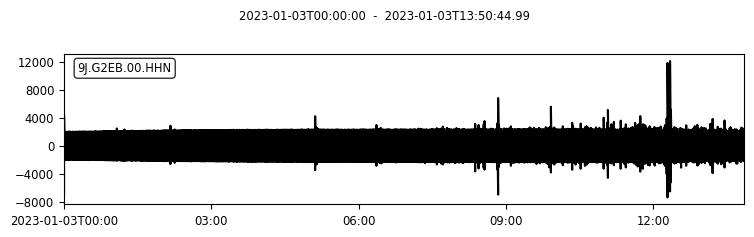

retrained_PhaseNet


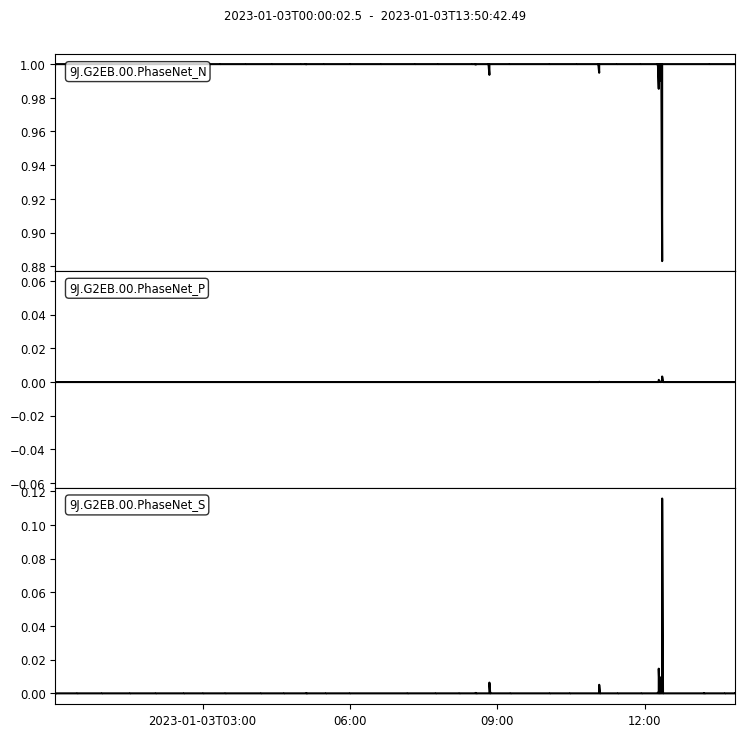

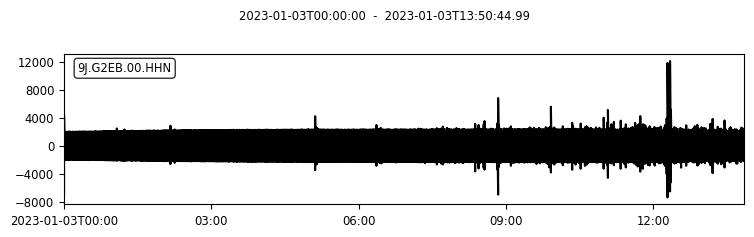

reference_PhaseNet


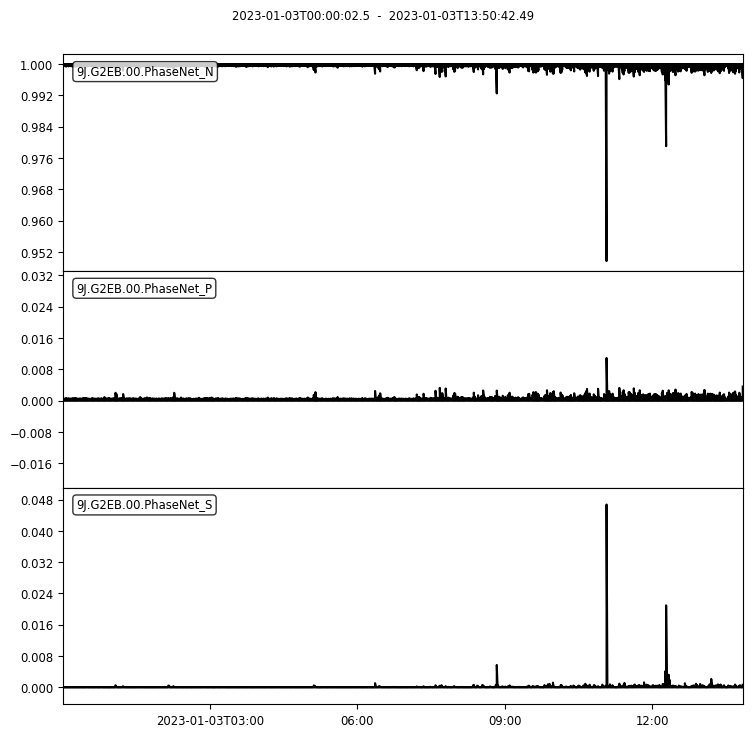

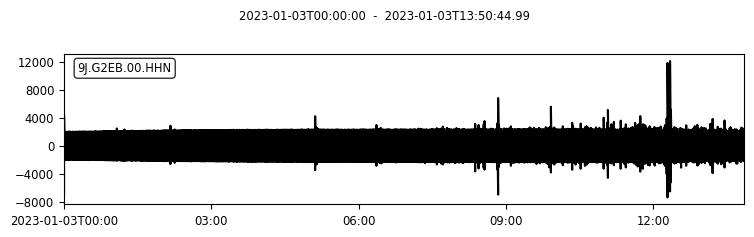

EQTransformer


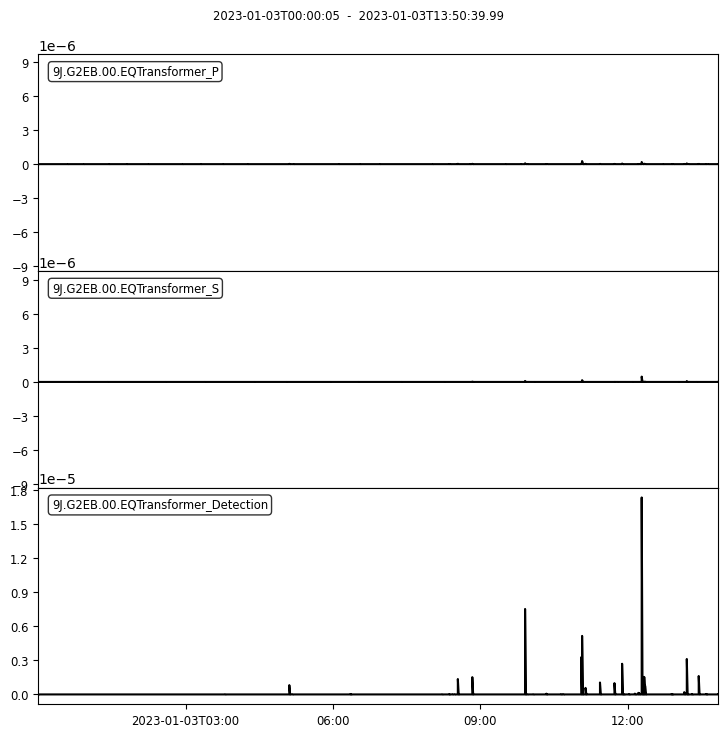

In [5]:
file = os.path.join(PICTS_BASE_PATH, "/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2023/9J/G2EB/HHN.D/9J.G2EB.00.HHN.D.2023.003")
print(file)
stream = obspy.read(file)
stream.filter("bandpass", freqmin=2, freqmax=8)

for name, model in models.items():
    print("\n")
    stream.plot()
    print(name)
    annotations = model.annotate(stream)
    annotations.plot()

/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2023/9J/G1WS/HHN.D/9J.G1WS.00.HHN.D.2023.106




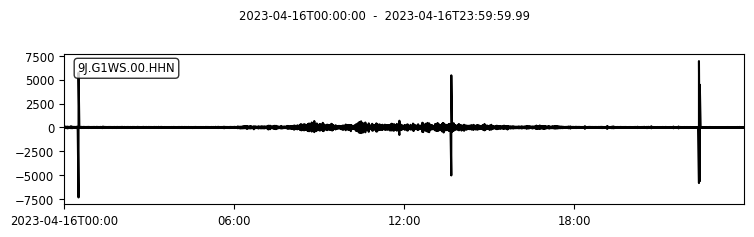

retrained_PhaseNet


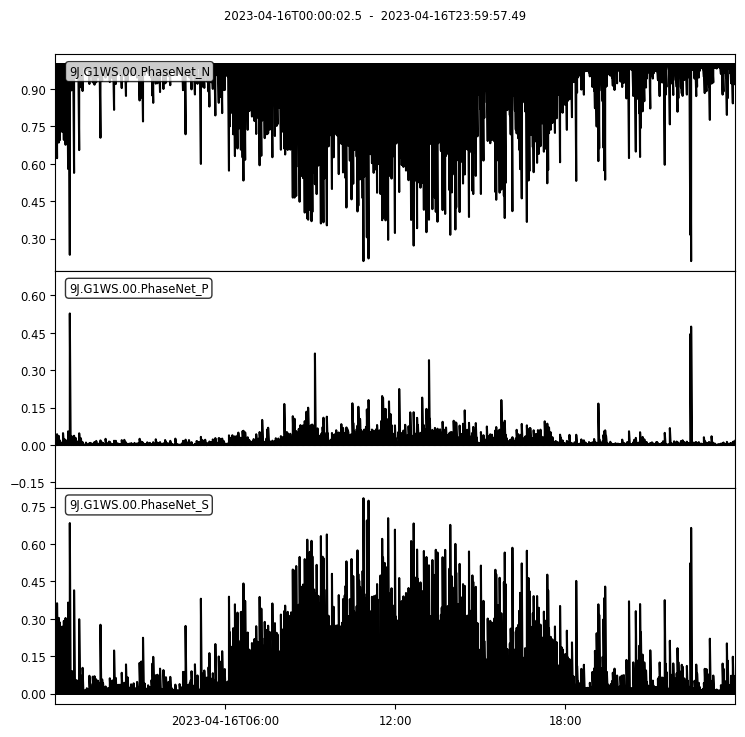

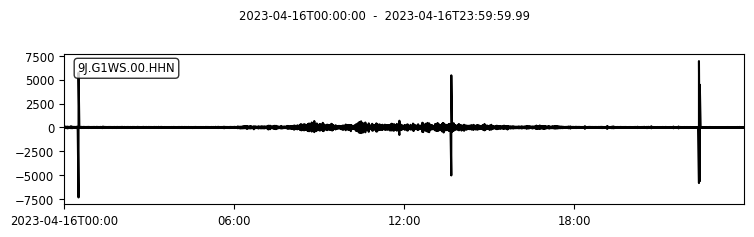

reference_PhaseNet


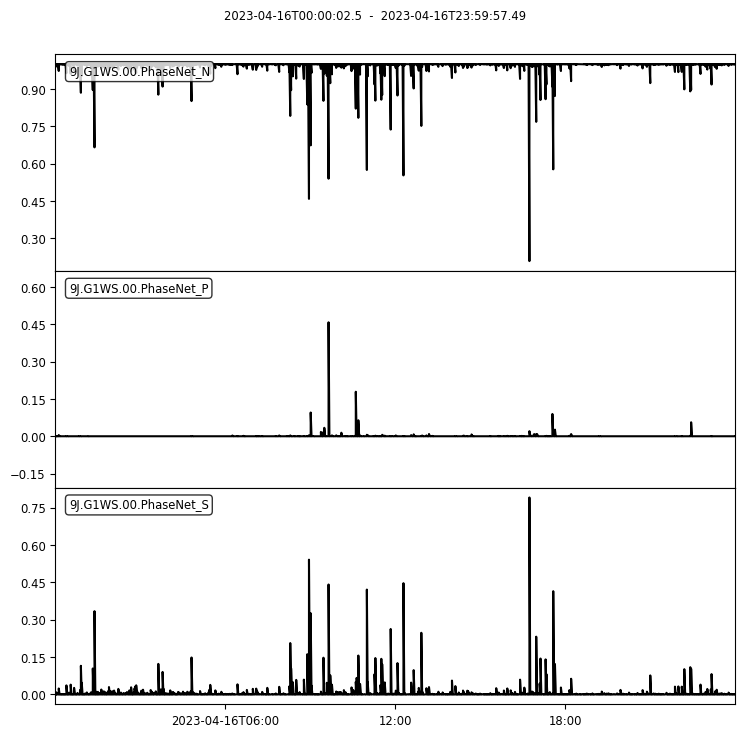

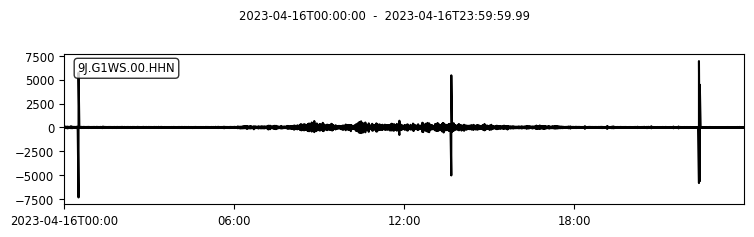

EQTransformer


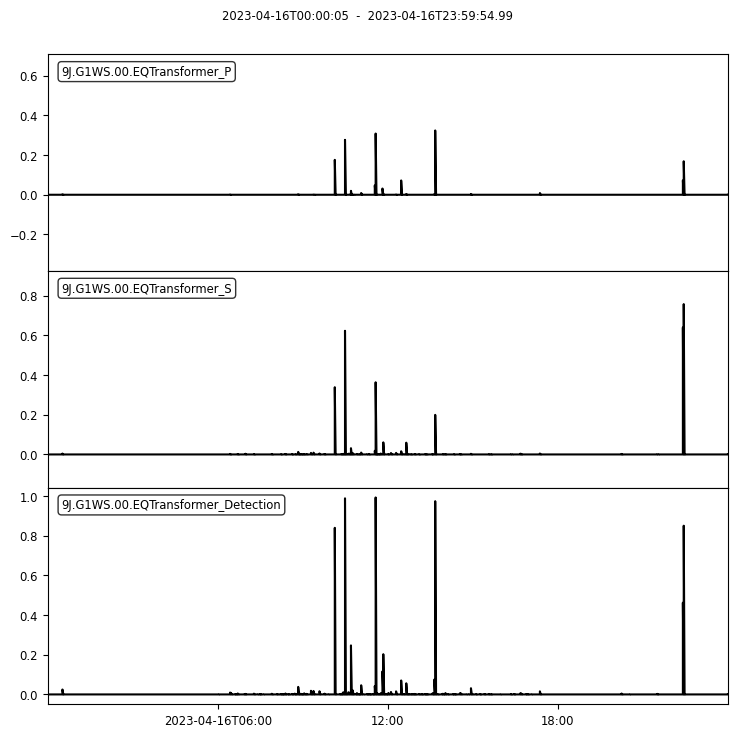

In [6]:
file = os.path.join(PICTS_BASE_PATH, "PICTS_DATA/2023/9J/G1WS/HHN.D/9J.G1WS.00.HHN.D.2023.106")
print(file)
stream = obspy.read(file)
stream.filter("bandpass", freqmin=2, freqmax=8)

for name, model in models.items():
    print("\n")
    stream.plot()
    print(name)
    annotations = model.annotate(stream)
    annotations.plot()

/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2023/9J/B1BC/HHE.D/9J.B1BC.00.HHE.D.2023.011




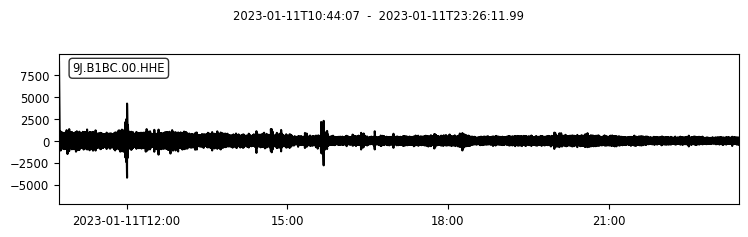

retrained_PhaseNet


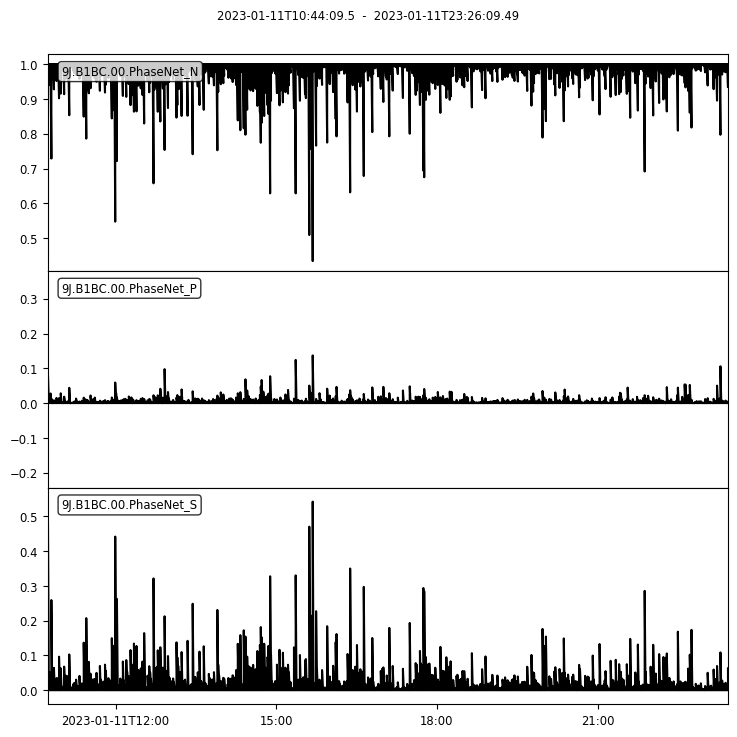

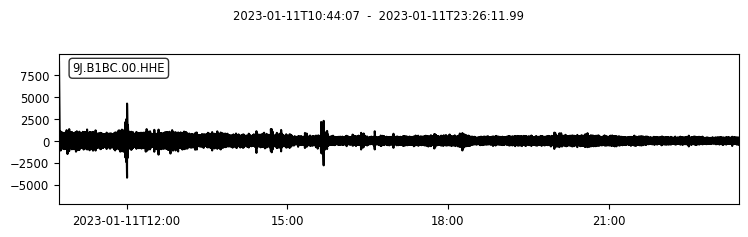

reference_PhaseNet


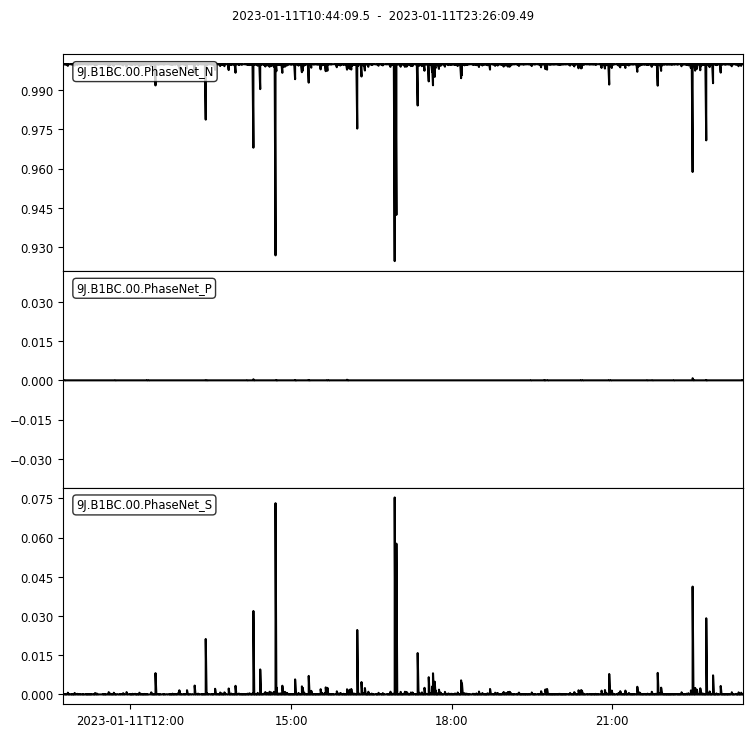

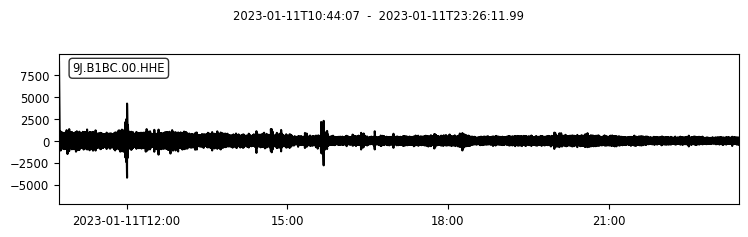

EQTransformer


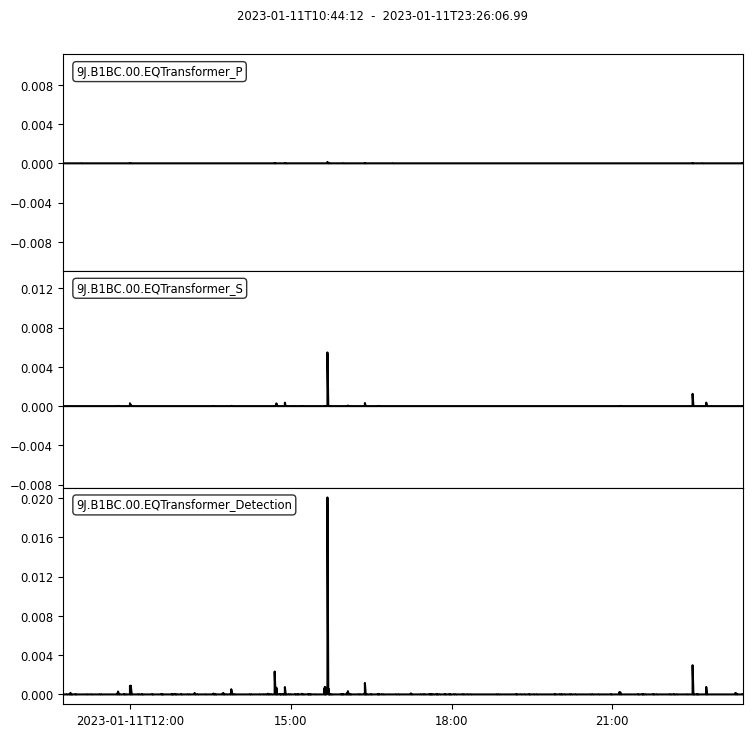

In [7]:
file = os.path.join(PICTS_BASE_PATH, "/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2023/9J/B1BC/HHE.D/9J.B1BC.00.HHE.D.2023.011")
print(file)
stream = obspy.read(file)
stream.filter("bandpass", freqmin=2, freqmax=8)

for name, model in models.items():
    print("\n")
    stream.plot()
    print(name)
    annotations = model.annotate(stream)
    annotations.plot()

/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2022/9J/G1WS/HHN.D/9J.G1WS.00.HHN.D.2022.100




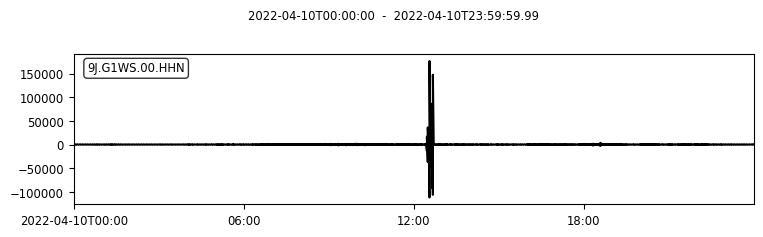

retrained_PhaseNet


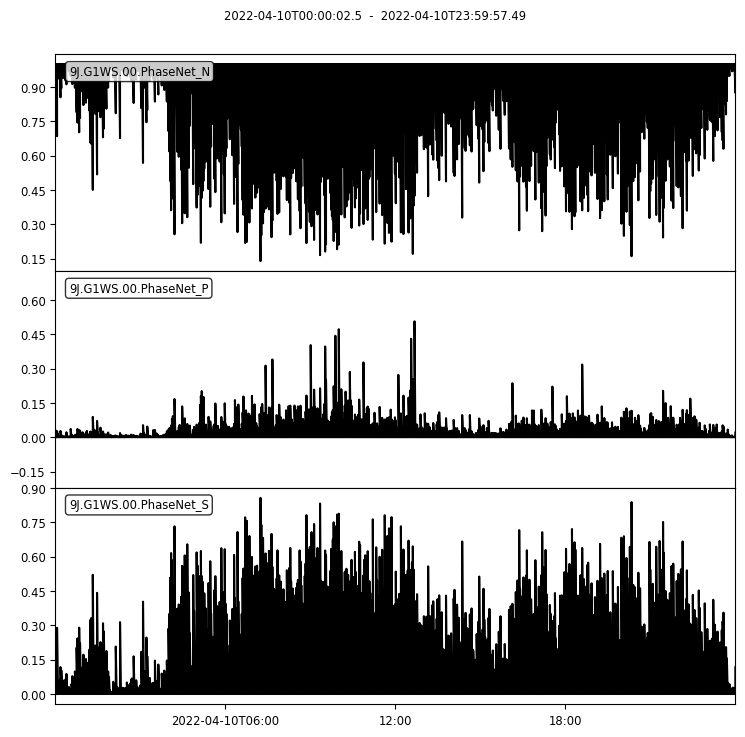

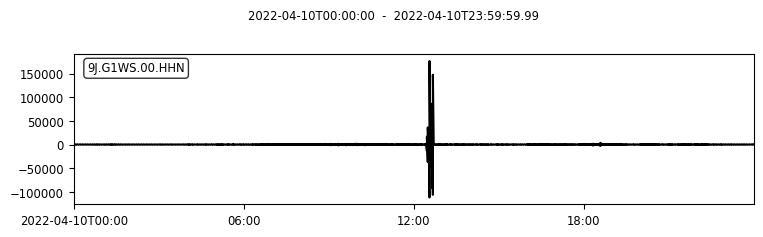

reference_PhaseNet


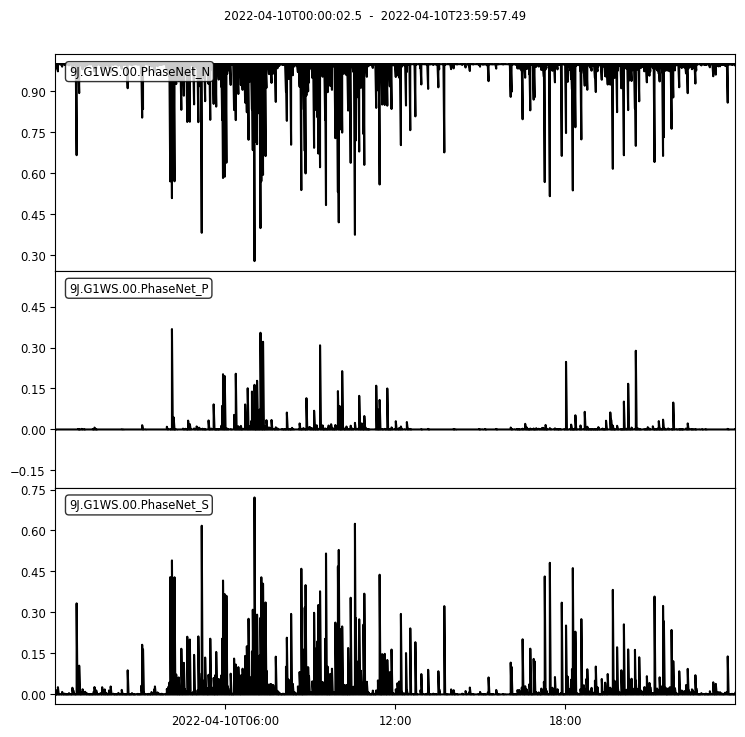

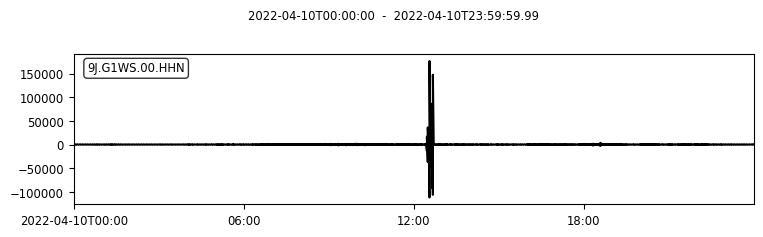

EQTransformer


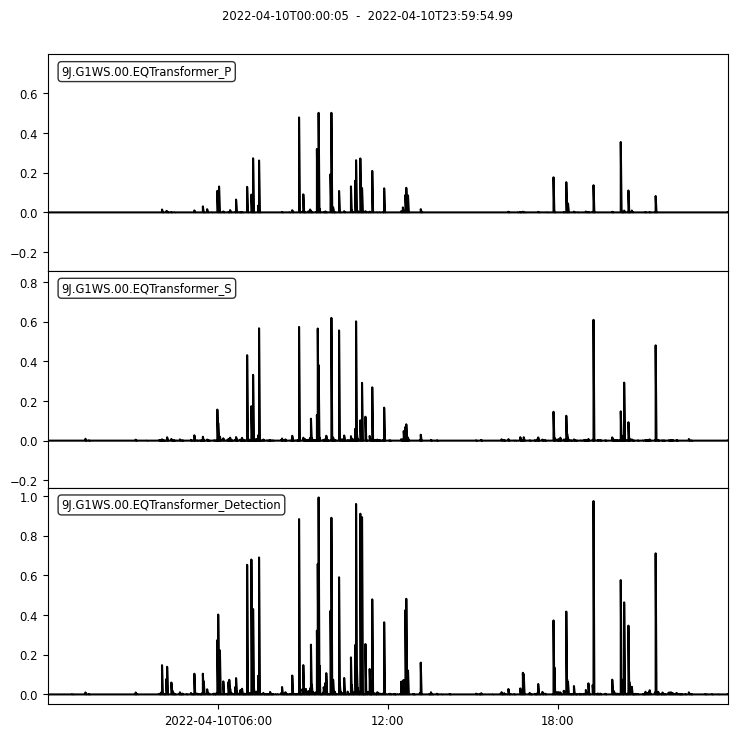

In [8]:
file = os.path.join(PICTS_BASE_PATH, "/run/media/dv1/Dave_T5/PICTS/from_corrupted_SSD/data/PICTS_DATA/2022/9J/G1WS/HHN.D/9J.G1WS.00.HHN.D.2022.100")
print(file)
stream = obspy.read(file)
stream.filter("bandpass", freqmin=2, freqmax=8)

for name, model in models.items():
    print("\n")
    stream.plot()
    print(name)
    annotations = model.annotate(stream)
    annotations.plot()